In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import sys
from UclaDataLoader import UclaDataLoader
from CedarsDataLoader import CedarsDataLoader
from CombineData import CombineData
from SplitData import SplitData
from TrainModel import TrainModel
from TestModel import TestModel
import viz_utils
import numpy as np
#from VisualizeResults import VisualizeResults

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ucla files
ddr_path= <path_to_ddr_files>
ucla_labs = os.path.join(ddr_path,'covid_labs.rpt')
ucla_encounters = os.path.join(ddr_path,'covid_encounters.rpt')
ucla_patients = os.path.join(ddr_path,'covid_patients.rpt')

# cedars files
cedars_patients = <path_to_cedars_patients_file>
cedars_flat_file = <path_to_cedars_flat_file>

# Read data #
dataSets = ['ucla', 'cedars']
dataDict = {}

anyInfMarker = True

excludeSupps = False

In [3]:
%%time
dataDict['ucla'] = {}
dataDict['ucla']['data'], dataDict['ucla']['trainIDs'], dataDict['ucla']['testIDs'] =\
    UclaDataLoader(ucla_labs, ucla_encounters, ucla_patients, anyInfMarker=anyInfMarker)

100%|██████████| 4941/4941 [00:02<00:00, 2371.68it/s]


Number of features: 21


100%|██████████| 3242/3242 [00:30<00:00, 106.82it/s]


CPU times: user 1min 12s, sys: 14.5 s, total: 1min 26s
Wall time: 1min 25s


In [4]:
immsuppfile = <path_to_ucla_immunosuppressed_file>
supps = pd.read_csv(immsuppfile, error_bad_lines=False)['PatientEncounterCSNID'].values
if excludeSupps:
    dataDict['ucla']['data']=dataDict['ucla']['data'].loc[\
                                    ~dataDict['ucla']['data']['PatientEncounterCSNID'].isin(supps)]
    dataDict['ucla']['trainIDs'] = [x for x in dataDict['ucla']['trainIDs'] if x not in supps]
    dataDict['ucla']['testIDs'] = [x for x in dataDict['ucla']['testIDs'] if x not in supps]

In [5]:
dataDict['cedars'] = {}
dataDict['cedars']['data'], dataDict['cedars']['trainIDs'], dataDict['cedars']['testIDs'] =\
    CedarsDataLoader(cedars_patients, cedars_flat_file, anyInfMarker=anyInfMarker)

In [6]:
print('Pool numbers:')
all_ucla = len(dataDict['ucla']['data'])
train_ucla = len(dataDict['ucla']['trainIDs'])
test_ucla = len(dataDict['ucla']['testIDs'])
all_cedars = len(dataDict['cedars']['data'])
train_cedars = len(dataDict['cedars']['trainIDs'])
test_cedars = len(dataDict['cedars']['testIDs'])
print('UCLA - all: %i, train: %i, test: %i' % (all_ucla,train_ucla,test_ucla))
print('Cedars - all: %i, train: %i, test: %i' % (all_cedars,train_cedars,test_cedars))

Pool numbers:
UCLA - all: 901, train: 901, test: 826
Cedars - all: 171, train: 171, test: 0


In [7]:
# Combine data #
allData, trainIDs, testIDs = CombineData(dataDict)

ucla samples: 901
cedars samples: 171


In [8]:
allData.groupby(by=['positive']).count()[['PatientEncounterCSNID']]

,PatientEncounterCSNID
positive,
0,786
1,286


In [9]:
# Dropping features, if necessary #
dropCols = ['D-DIMER']#, 'Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
allData = allData.drop(dropCols, axis=1)

randSt=np.random.RandomState(10)

In [10]:
# Split data #
trainData, valData, testData = SplitData(allData, trainIDs, testIDs, n_val=30, n_test=60, balanced=False,random_state=7)

CPU times: user 13h 15min 32s, sys: 20min, total: 13h 35min 33s
Wall time: 22min 25s


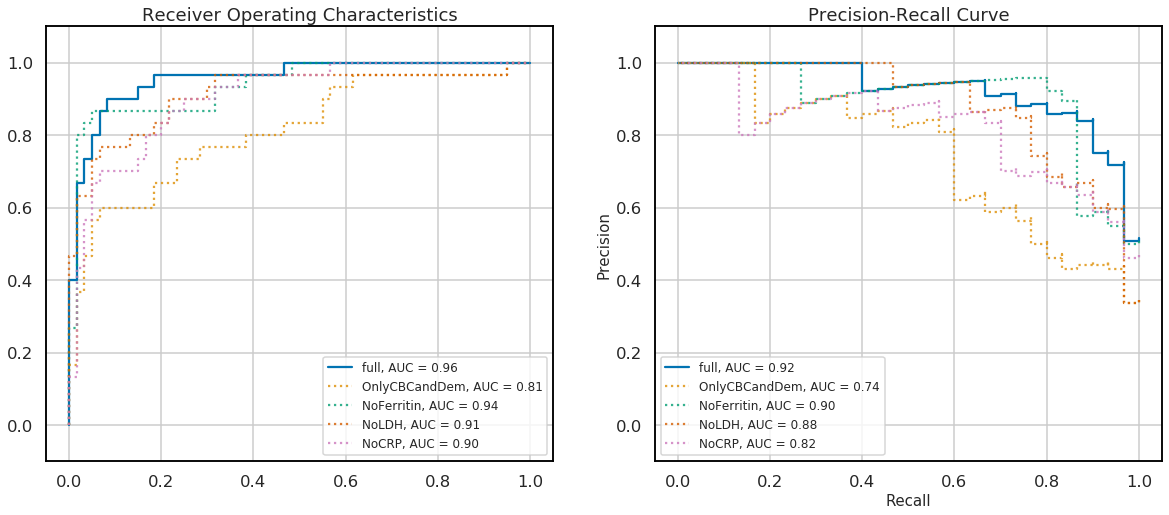

In [11]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')
experiments={}
expnames=['full', 'OnlyCBCandDem', 'NoFerritin', 'NoLDH', 'NoCRP']

y_vectors = {}

f2, axarr2 = plt.subplots(1, 2, figsize=(20, 8))
axarr2[0].set_title('Receiver Operating Characteristics', fontsize=18)
axarr2[0].set_ylim((-0.1,1.1))
axarr2[1].set_title('Precision-Recall Curve', fontsize=18)
axarr2[1].set_ylim((-0.1,1.1))

for exp in expnames:
    y_vectors[exp]={}
    colToDrop = []
    if exp == 'OnlyCBCandDem':
        colToDrop = ['Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
    if exp == 'NoFerritin':
        colToDrop = ['Ferritin']
    if exp == 'NoLDH':
        colToDrop = ['Lactate Dehydrogenase']
    if exp == 'NoCRP':
        colToDrop = ['C-Reactive Protein']
        
    # Train and tune model #
    model = TrainModel(trainData.drop(colToDrop, axis=1), valData.drop(colToDrop, axis=1),\
                       iterations=10, beta=2, minThr=15, maxThr=40)
    
    # Test model #
    results = TestModel(model, testData.drop(colToDrop, axis=1), showReport=False)
    
    y_test=results['y_test']
    y_prob=results['y_prob']
    y_pred=results['y_pred']
    y_vectors[exp]['y_test']=y_test
    y_vectors[exp]['y_prob']=y_prob
    y_vectors[exp]['y_pred']=y_pred


    fpr,tpr,thr,auc = results['roc']['fpr'], results['roc']['tpr'], results['roc']['thr'], results['roc']['auc']
    prec, rec, pr_auc = results['prcurve']['precisions'], results['prcurve']['recalls'], results['prcurve']['auc']


    if exp=='full':
        axarr2[0].plot(fpr,tpr, label=exp+', AUC = %.2f' % auc,linestyle='-', alpha=1.0)
        axarr2[1].step(rec,prec, label=exp+', AUC = %.2f' % pr_auc,linestyle='-', alpha=1.0)
    else:
        axarr2[0].plot(fpr,tpr, label=exp+', AUC = %.2f' % auc,linestyle=':', alpha=0.8)
        axarr2[1].step(rec,prec, label=exp+', AUC = %.2f' % pr_auc,linestyle=':', alpha=0.8)
            

axarr2[1].set_xlabel('Recall', fontsize=15)
axarr2[1].set_ylabel('Precision', fontsize=15)
axarr2[0].legend(fontsize=12)
axarr2[1].legend(fontsize=12)

Precision: 0.95
Recall: 0.67
AUC: 0.82
F(1.0): 0.78
Index(['Hemoglobin', 'Absolute Lymphocyte Count', 'Absolute Neut Count',
       'PLATELET COUNT, AUTO', 'C-Reactive Protein', 'Ferritin',
       'Absolute Baso Count', 'Absolute Eos Count', 'Absolute Mono Count',
       'Lactate Dehydrogenase', 'Red Blood Cell Count', 'Lymp/Neut', 'Age',
       'Male'],
      dtype='object')
Index(['C-Reactive Protein', 'Ferritin', 'Lactate Dehydrogenase', 'Lymp/Neut',
       'Red Blood Cell Count', 'Absolute Mono Count', 'Absolute Eos Count',
       'Absolute Baso Count', 'PLATELET COUNT, AUTO', 'Absolute Neut Count',
       'Absolute Lymphocyte Count', 'Hemoglobin', 'Male', 'Age'],
      dtype='object')


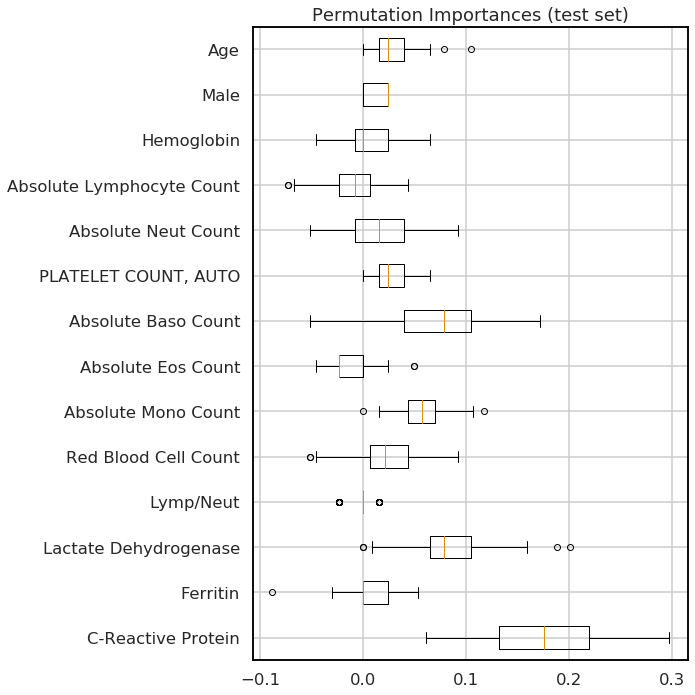

CPU times: user 15.3 s, sys: 666 ms, total: 16 s
Wall time: 1min 20s


In [17]:
%%time
viz_utils.plot_feature_importance(model,testData, n_repeats=100)

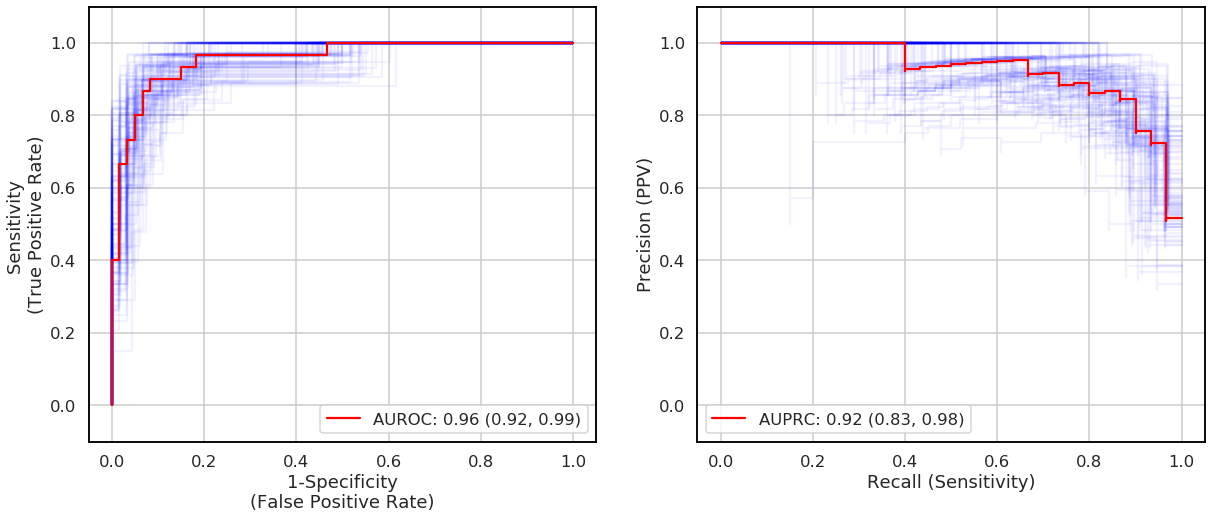

In [18]:
import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')
viz_utils.plot_results(y_vectors['full']['y_test'], y_vectors['full']['y_prob'], saveFigs=False, legend=True)